# **AQI - Exploratory Data Analysis**

This notebook performs exploratory data analysis on the AQI and weather data to understand patterns, correlations, and prepare for predictive modeling.

---
---

### 1. Project Setup & Data Loading

Sets up the environment, connects to the database, and loads the dataset.

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Path Configuration
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Load Environment & Database
load_dotenv()
from src.database import AQIDatabase

plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

# Fetch Data
try:
    db = AQIDatabase()
    df = db.fetch_data()
    print(f"Data Connection Established. Records found: {len(df)}")
except Exception as e:
    print(f"Connection Error: {e}")


Connected to MongoDB.
Data Connection Established. Records found: 4464


### 2. Preprocessing

Converts dates to the index, handles the ~11 missing values using forward-fill (appropriate for time-series), and sorts the data.

In [3]:
# Convert timestamps and set index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.sort_index()

# Handle the 11 missing values (Forward Fill)
df = df.ffill()

# Create features for analysis
df['hour'] = df.index.hour
df['day_name'] = df.index.day_name()

print("Data Cleaning Complete. Missing values remaining:")
print(df.isnull().sum().sum())


Data Cleaning Complete. Missing values remaining:
0


### 3. Distribution of AQI

A professional histogram showing the frequency of AQI values. The red dashed line indicates the average AQI.

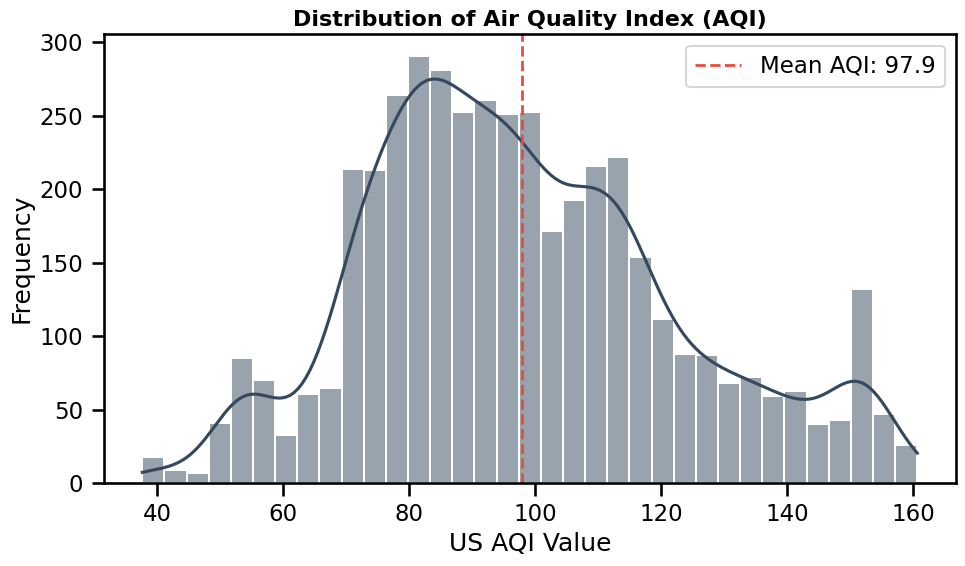

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['us_aqi'], kde=True, bins=35, color='#34495e', edgecolor='white')

# Add Mean Line
mean_val = df['us_aqi'].mean()
plt.axvline(mean_val, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean AQI: {mean_val:.1f}')

plt.title('Distribution of Air Quality Index (AQI)', fontweight='bold')
plt.xlabel('US AQI Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


### 4. Pollutant Correlation Matrix

A heatmap displaying the relationship between different pollutants. Higher values (red) indicate a stronger positive correlation.


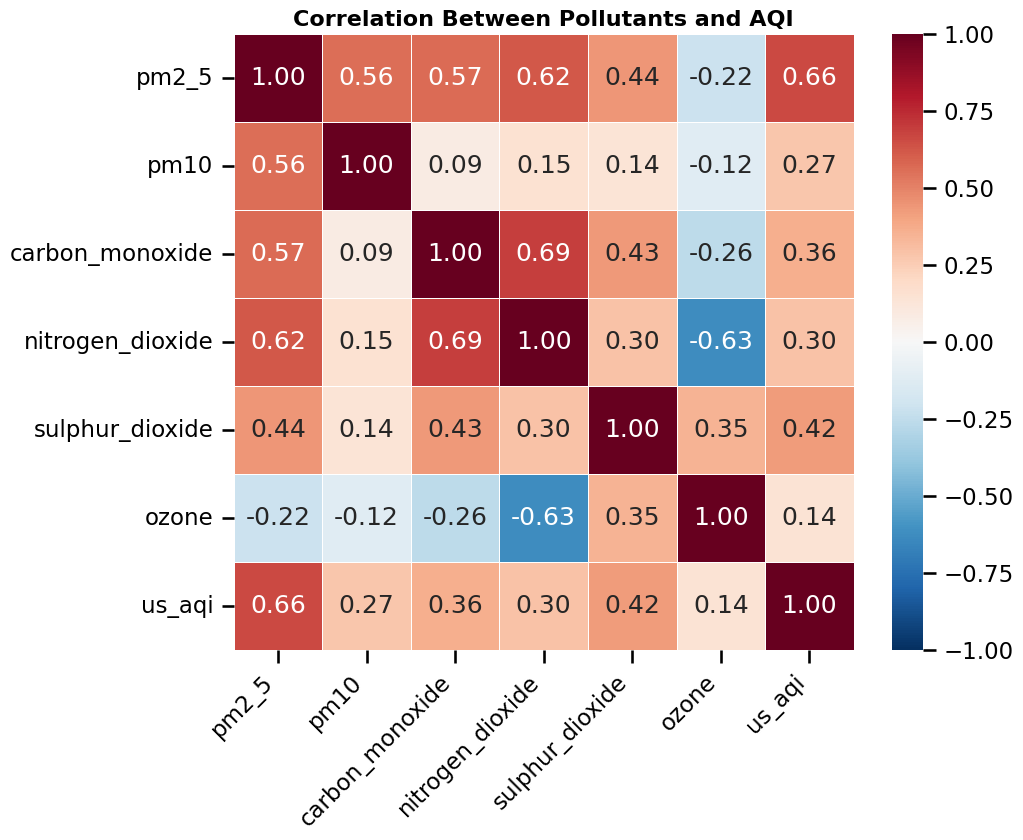

In [5]:
plt.figure(figsize=(10, 8))

# Calculate correlation
cols = ['pm2_5', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'us_aqi']
corr = df[cols].corr()

# Plot Heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1,
            linewidths=0.5, linecolor='white')

plt.title('Correlation Between Pollutants and AQI')
plt.xticks(rotation=45, ha='right')
plt.show()


### 5. Historical AQI Trends

Visualizes the hourly AQI fluctuations (grey) alongside a smoothed 24-hour moving average (blue) to highlight daily trends.


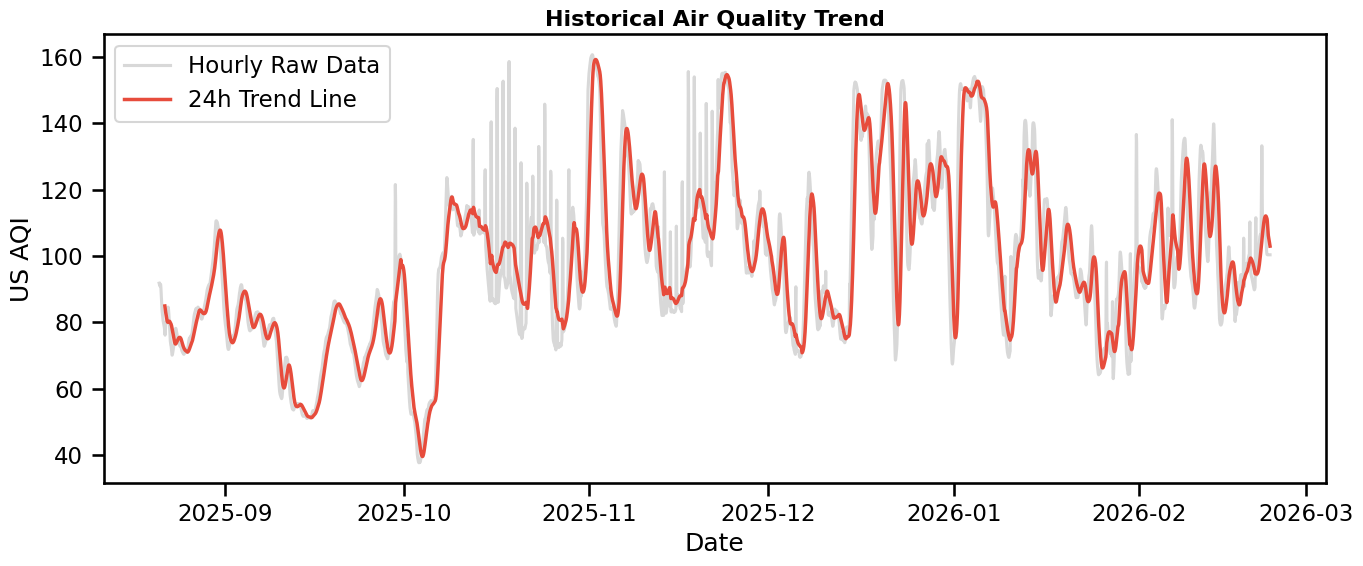

In [6]:
plt.figure(figsize=(14, 6))

# Raw Data (Grey)
plt.plot(df.index, df['us_aqi'], color='grey', alpha=0.3, label='Hourly Raw Data')

# 24-Hour Moving Average (Red)
plt.plot(df.index, df['us_aqi'].rolling(24).mean(), color='#e74c3c', linewidth=2.5, label='24h Trend Line')

plt.title('Historical Air Quality Trend')
plt.xlabel('Date')
plt.ylabel('US AQI')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### 6. Hourly Patterns

A boxplot showing the spread of AQI values for each hour of the day. This reveals peak pollution times (e.g., morning/evening rush hours).


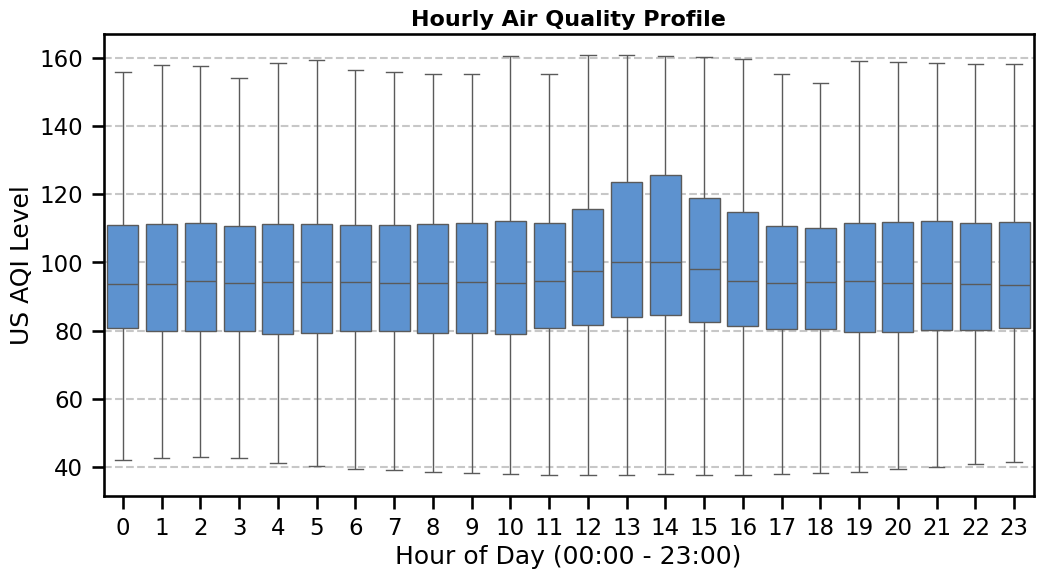

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot of AQI by Hour
sns.boxplot(x='hour', y='us_aqi', data=df, color='#4a90e2', showfliers=False)

plt.title('Hourly Air Quality Profile')
plt.xlabel('Hour of Day (00:00 - 23:00)')
plt.ylabel('US AQI Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 7. Weekly Analysis

Bar chart showing the average AQI for each day of the week, with exact values labeled on top of each bar.


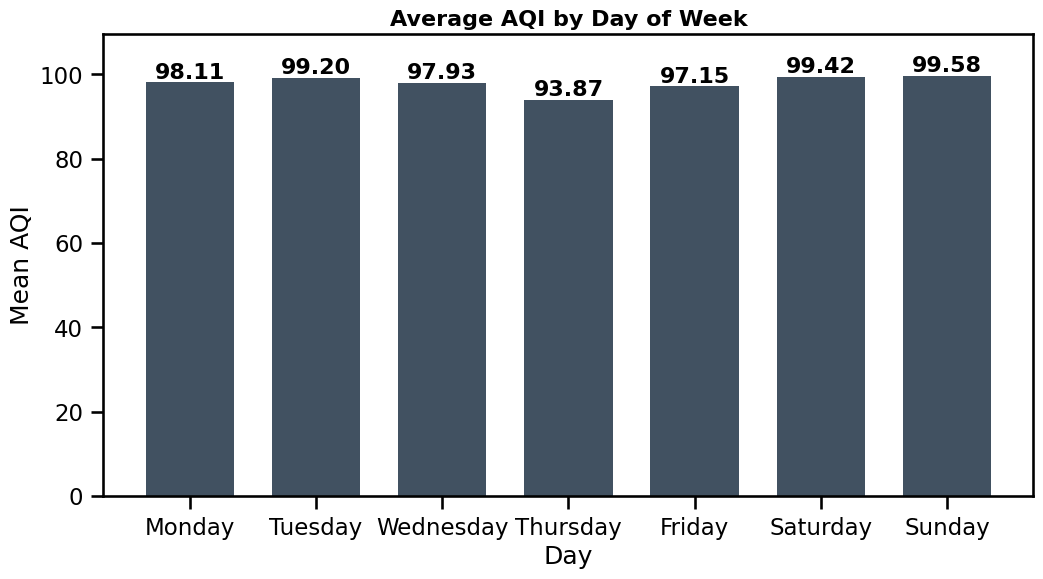

In [8]:
# Order days correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = df.groupby('day_name')['us_aqi'].mean().reindex(days_order)

plt.figure(figsize=(12, 6))

# Create Bar Chart
bars = plt.bar(weekly_avg.index, weekly_avg.values, color='#2c3e50', alpha=0.9, width=0.7)

# Add Labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=16, fontweight='bold')

plt.title('Average AQI by Day of Week')
plt.xlabel('Day')
plt.ylabel('Mean AQI')
plt.ylim(0, weekly_avg.max() * 1.10)
plt.show()


---

### **Key Findings**

In [ ]:
# Final Report Summary

print("=" * 80)
print("KEY FINDINGS FOR KARACHI AQI PREDICTION MODEL")
print("=" * 80)

# 1. Data Quality
print("\n1. DATA QUALITY:")
print(f"   - Total records: {len(df)}")
print(f"   - Date range: {df.index.min().date()} to {df.index.max().date()}")
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    print(f"   - Missing values detected: {missing_count} (handled via forward-fill)")
else:
    print("   - No missing values - data is complete!")

# 2. Target Variable (US AQI Categories)
print("\n2. TARGET VARIABLE (US AQI DISTRIBUTION):")
# Helper to categorize AQI for the report
def get_aqi_category(x):
    if x <= 50: return 'Good'
    elif x <= 100: return 'Moderate'
    elif x <= 150: return 'Unhealthy (Sensitive)'
    elif x <= 200: return 'Unhealthy'
    elif x <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

aqi_cats = df['us_aqi'].apply(get_aqi_category)
aqi_dist = aqi_cats.value_counts(normalize=True) * 100
for level, pct in aqi_dist.items():
    print(f"   - {level}: {pct:.1f}%")

# 3. Correlation Analysis
print("\n3. TOP CORRELATED FEATURES WITH AQI:")
# Calculate correlation with target, exclude target itself
numeric_df = df.select_dtypes(include=[np.number])
corrs = numeric_df.corr()['us_aqi'].drop('us_aqi').abs().sort_values(ascending=False).head(5)
for feature, corr in corrs.items():
    print(f"   - {feature}: {corr:.3f}")

# 4. Temporal Patterns
print("\n4. TEMPORAL PATTERNS:")
hourly_aqi = df.groupby('hour')['us_aqi'].mean()
print(f"   - Peak AQI hour: {hourly_aqi.idxmax()}:00 (avg: {hourly_aqi.max():.2f})")
print(f"   - Lowest AQI hour: {hourly_aqi.idxmin()}:00 (avg: {hourly_aqi.min():.2f})")

# Monthly check (create month column temporarily if needed)
df['month'] = df.index.month_name()
monthly_aqi = df.groupby('month')['us_aqi'].mean()
if len(monthly_aqi) > 1:
    print(f"   - Worst month: {monthly_aqi.idxmax()} (avg: {monthly_aqi.max():.2f})")
    print(f"   - Best month: {monthly_aqi.idxmin()} (avg: {monthly_aqi.min():.2f})")

# 5. Recommendations
print("\n5. MODELING RECOMMENDATIONS:")
print("   - Primary Feature: Focus on PM2.5 as it has the highest correlation.")
print("   - Feature Engineering: Add lag features (e.g., lag_1h, lag_24h) to capture the diurnal cycle.")
print("   - Data Scaling: Normalize features to handle the varying ranges of pollutants.")
print("   - Model Selection: Tree-based models (XGBoost/Random Forest) recommended for non-linear patterns.")
print("   - Retraining: Update model daily to adapt to changing seasonal baselines.")

print("\n" + "=" * 80)


KEY FINDINGS FOR KARACHI AQI PREDICTION MODEL

1. DATA QUALITY:
   - Total records: 4464
   - Date range: 2025-08-21 to 2026-02-22
   - No missing values - data is complete!

2. TARGET VARIABLE (US AQI DISTRIBUTION):
   - Moderate: 57.3%
   - Unhealthy (Sensitive): 37.1%
   - Unhealthy: 4.7%
   - Good: 0.9%

3. TOP CORRELATED FEATURES WITH AQI:
   - pm2_5: 0.657
   - sulphur_dioxide: 0.424
   - carbon_monoxide: 0.361
   - nitrogen_dioxide: 0.296
   - pm10: 0.274

4. TEMPORAL PATTERNS:
   - Peak AQI hour: 14:00 (avg: 104.42)
   - Lowest AQI hour: 10:00 (avg: 96.78)
   - Worst month: November (avg: 113.05)
   - Best month: September (avg: 73.61)

5. MODELING RECOMMENDATIONS:
   - Primary Feature: Focus on PM2.5 as it has the highest correlation.
   - Feature Engineering: Add lag features (e.g., lag_1h, lag_24h) to capture the diurnal cycle.
   - Data Scaling: Normalize features to handle the varying ranges of pollutants.
   - Model Selection: Tree-based models (XGBoost/Random Forest) rec